In [1]:
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
questions = pd.read_csv('data/Continuous/CombinedContinuousDataWithCategories.csv')
questions

,QuestionText,Answer,Year,Categories,AnswerChoices
0,How many Federally Insured Commercial Banks in...,0.420490,2018,['Stock Market'],"{'type': 'continuous', 'scale': {'max': 5500, ..."
1,When will an AI system score an impressive def...,0.376395,2019,[],"{'type': 'continuous', 'scale': {'max': '2030-..."
2,When will programs write programs for us?,0.408719,2021,"['Technology', 'Health and Epidemiology']","{'type': 'continuous', 'scale': {'max': '2050-..."
3,When will the first exaflop performer appear?,0.849452,2022,"['Technology', 'Political', 'Sports', 'Health ...","{'type': 'continuous', 'scale': {'max': '2025-..."
4,When will the first law concerning artificial ...,0.260335,2021,['Health and Epidemiology'],"{'type': 'continuous', 'scale': {'max': '2060-..."
...,...,...,...,...,...
2532,What will be the 7-day moving average of daily...,0.168667,2022,[],"{'max': 15000, 'min': 0, 'deriv_ratio': 1}"
2533,What will be the 7-day moving average of daily...,0.214533,2022,[],"{'max': 15000, 'min': 0, 'deriv_ratio': 1}"
2534,What will be the 7-day moving average of curre...,0.069975,2022,[],"{'max': 4000, 'min': 0, 'deriv_ratio': 1}"
2535,What will be the 7-day moving average of curre...,0.121100,2022,[],"{'max': 4000, 'min': 0, 'deriv_ratio': 1}"


In [3]:
allYears = sorted(list(questions['Year'].unique()))
allYears

[2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [4]:
allCategories = [
    'Technology',
    'Political',
    'Sports',
    'Health and Epidemiology',
    'Stock Market',
    'Supply Chain'
]

In [5]:
dateCounter = 0
datePred = []
mins, maxes = [], []
for ans in questions['AnswerChoices']:
    ans = ast.literal_eval(ans)
    if 'max' in ans:
        try:
            maxes.append(int(ans['max']))
            mins.append(int(ans['min']))
            datePred.append(False)
        except:
            startDate = [int(x) for x in ans['max'].split('-')]
            maxes.append(startDate[0])
            endDate = [int(x) for x in ans['min'].split('-')]
            mins.append(endDate[0])
            dateCounter += 1
            datePred.append(True)
    else:
        if ans['format'] != 'date':
            maxes.append(int(ans['scale']['max']))
            mins.append(int(ans['scale']['min']))
            datePred.append(False)
        else:
            startDate = [int(x) for x in ans['scale']['max'].split('-')]
            maxes.append(startDate[0])
            endDate = [int(x) for x in ans['scale']['min'].split('-')]
            mins.append(startDate[0])
            dateCounter += 1
            datePred.append(True)

means = [(mins[i]+maxes[i])/2 for i in range(len(maxes))]
questions['IsDate'] = datePred

In [6]:
print(f'Number of rows with dates as answers: {dateCounter}')

Number of rows with dates as answers: 422


In [7]:
def getClosestAnswer(preds, mean):
    preds = sorted(preds, key = lambda x: abs(x-mean))
    return preds[0]

In [8]:
def getResults(pred):
    totalErrors = []
    dateErrors = []
    
    totalError, noneCounter, totalNum, dateError, dateNum = 0, 0, 0, 0, 0
    
    for i in range(len(pred['Predictions'])):
        if len(pred["Predictions"][i]) == 0:
            noneCounter += 1
            continue
            
        if len(pred["Predictions"][i]) > 1:
            try:
                tempAns = getClosestAnswer(pred["Predictions"][i], means[i])
            except:
                noneCounter += 1
                continue
        else:
            tempAns = pred['Predictions'][i][0]
            
        
        denom = (maxes[i]-pred['Answer'][i]*(maxes[i]-mins[i]))
        
        if denom == 0 or tempAns < mins[i] or tempAns > maxes[i]:
            noneCounter += 1
            continue
            
        if pred['IsDate'][i] == True:
            dateNum += 1
            # dateError += abs(tempAns - (pred['Answer'][i]*(maxes[i]-mins[i])+mins[i]))/denom
            dateError += abs(tempAns - (pred['Answer'][i]*(maxes[i]-mins[i])-maxes[i]))/denom
            dateErrors.append(abs(tempAns - (pred['Answer'][i]*(maxes[i]-mins[i])-maxes[i]))/denom)
        else:
            totalError += abs(tempAns - (pred['Answer'][i]*(maxes[i]-mins[i])-maxes[i]))/denom
            totalNum += 1
            totalErrors.append(abs(tempAns - (pred['Answer'][i]*(maxes[i]-mins[i])-maxes[i]))/denom)
    
    ret = (
        totalError/totalNum if totalNum != 0 else None,
        totalNum,
        #totalErrors,
        dateError/dateNum if dateNum != 0 else None,
        dateNum,
        #dateErrors,
        noneCounter
    )
    return ret

### WizardLM

In [9]:
WLMData = pd.read_csv('data/Continuous/WizardContinuous0-2536.csv')

In [10]:
nos = []
for row in WLMData['predictions']:
    if not 'as an ai language model' in row.lower() and not 'ai developed by openai' in row.lower():
        row = re.sub(r'\W+', '', row)
        temp = re.findall(r'\d+', row)
        nos.append(list(map(int, temp)))
    else:
        nos.append([])

WLMTotal = questions.copy(deep=True)
WLMTotal['Predictions'] = nos

In [11]:
WLMres = getResults(WLMTotal)

In [12]:
WLMres

(1.7535173288076062, 1000, 1.9998995112121118, 51, 1486)

#### Years

In [51]:
WLMyearsData = {}

for year in allYears:
    yearData = WLMTotal[WLMTotal['Year']==year]
    yearData = yearData.reset_index()
    WLMyearsData[year] = getResults(yearData)  

In [76]:
for i in range(len(WLMTotal['Year'])):
    WLMTotal['Year'][i] = int(WLMTotal['Year'][i])

C:\Users\vetur\AppData\Local\Temp\ipykernel_2232\1591614585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WLMTotal['Year'][i] = int(WLMTotal['Year'][i])


In [79]:
#before
temp1 = WLMTotal[WLMTotal['Year'] < 2022]
temp1 = temp1.reset_index()
getResults(temp1)

(1.5826131602450746, 222, 1.2981782523757073, 51, 1142)

In [80]:
#after
temp2 = WLMTotal[WLMTotal['Year'] >= 2022]
temp2 = temp2.reset_index()
getResults(temp2)

(1.5337942924063956, 163, 0.9541063819182637, 26, 933)

In [52]:
WLMyearsData[2019]

(0.7374132478737527,
 5,
 [-0.993,
  1.1854545454545455,
  1.1510204081632653,
  1.0084366405741028,
  1.3351546451768501],
 None,
 0,
 [],
 66)

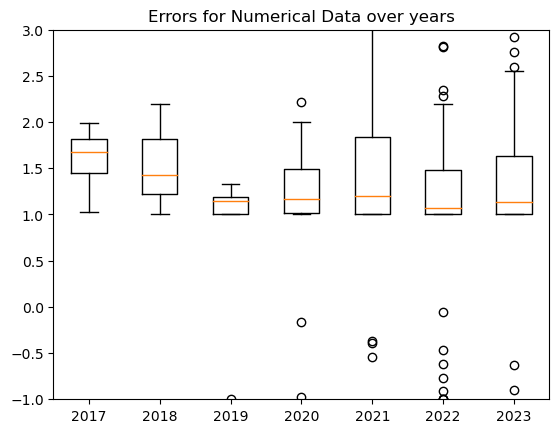

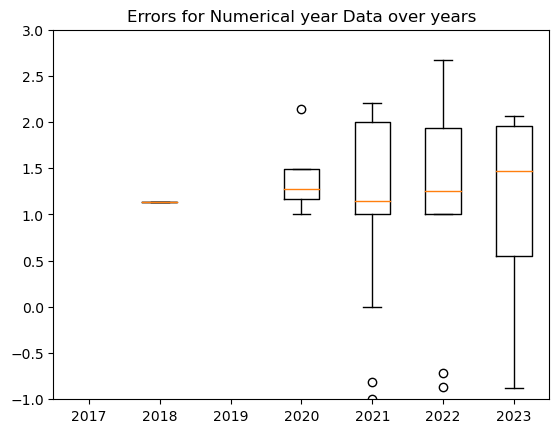

In [53]:
WLMyearsDict = {year: WLMyearsData[year][2] for year in allYears}
WLMyearsDatesDict = {year: WLMyearsData[year][5] for year in allYears}

fig, ax = plt.subplots()
plt.title('Errors for Numerical Data over years')

ax.boxplot(WLMyearsDict.values())
ax.set_xticklabels(WLMyearsDict.keys())
ax.set_ylim([-1, 3])
plt.show()


fig, ax = plt.subplots()
plt.title('Errors for Numerical year Data over years')
ax.boxplot(WLMyearsDatesDict.values())
ax.set_xticklabels(WLMyearsDatesDict.keys())
ax.set_ylim([-1, 3])
plt.show()



#### Categories

In [13]:
present = {cat:[] for cat in allCategories}

for i in range(len(WLMTotal['Categories'])):
    WLMTotal['Categories'][i] = ast.literal_eval(WLMTotal['Categories'][i])
    for cat in present:
        if cat in WLMTotal['Categories'][i]:
            present[cat].append(True)
        else:
            present[cat].append(False)

for cat in present:
    WLMTotal[cat] = present[cat]

C:\Users\vetur\AppData\Local\Temp\ipykernel_11236\2488170240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WLMTotal['Categories'][i] = ast.literal_eval(WLMTotal['Categories'][i])


In [17]:
WLMcategoriesData = {}
for category in allCategories:
    categoryData = WLMTotal[WLMTotal[category]]
    categoryData = categoryData.reset_index()
    WLMcategoriesData[category] = getResults(categoryData)
    print(f'WizardLM & {category} & {round(WLMcategoriesData[category][0], 4)} & {round(WLMcategoriesData[category][2], 4)} & {round(WLMcategoriesData[category][4]/(WLMcategoriesData[category][4] + WLMcategoriesData[category][1] + WLMcategoriesData[category][3]), 4)} \\')
    print("\hline")



WizardLM & Technology & 1.1806 & 0.6102 & 0.822 \
\hline
WizardLM & Political & 1.0942 & 0.9962 & 0.843 \
\hline
WizardLM & Sports & 1.2168 & 0.8191 & 0.8432 \
\hline
WizardLM & Health and Epidemiology & 1.3299 & 1.1491 & 0.8261 \
\hline
WizardLM & Stock Market & 1.5276 & 1.1653 & 0.8 \
\hline
WizardLM & Supply Chain & 1.2447 & 1.1866 & 0.8211 \
\hline


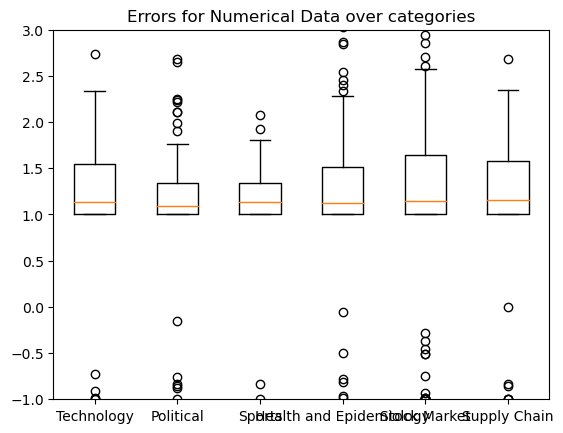

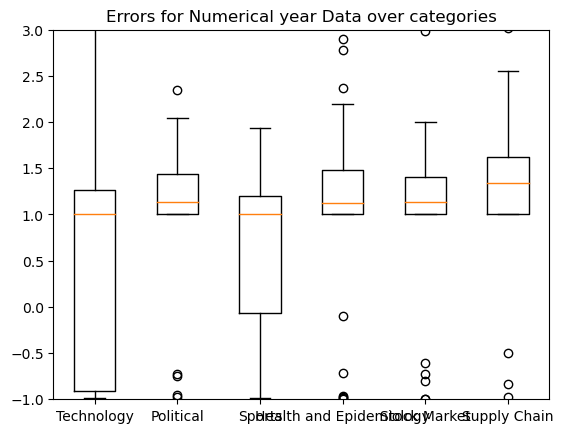

In [39]:
WLMcatsDict = {cat: WLMcategoriesData[cat][2] for cat in allCategories}
WLMcatsDatesDict = {cat: WLMcategoriesData[cat][5] for cat in allCategories}

fig, ax = plt.subplots()
plt.title('Errors for Numerical Data over categories')

ax.boxplot(WLMcatsDict.values())
ax.set_xticklabels(WLMcatsDict.keys())
ax.set_ylim([-1, 3])
plt.show()


fig, ax = plt.subplots()
plt.title('Errors for Numerical year Data over categories')
ax.boxplot(WLMcatsDatesDict.values())
ax.set_xticklabels(WLMcatsDatesDict.keys())
ax.set_ylim([-1, 3])
plt.show()

### Hermes

In [18]:
HermesData = pd.read_csv('data/Continuous/HermesContinuous0-2536.csv')
HermesData

,Unnamed: 0,predictions
0,0,"There were approximately 5,693 Federally Insu..."
1,1,"It is difficult to predict the exact date, bu..."
2,2,"It is difficult to predict an exact date, but..."
3,3,"An ""exaflop"" is a measure of computer perform..."
4,4,The first law concerning artificial intellige...
...,...,...
2532,2532,I am unable to provide a specific number as a...
2533,2533,I am unable to provide a specific number as a...
2534,2534,I am unable to provide a specific number as a...
2535,2535,I am unable to provide a specific number as a...


In [19]:
nos = []
for row in HermesData['predictions']:
    if not 'i am unable to provide' in row.lower():
        row = re.sub(r'\W+', '', row)
        temp = re.findall(r'\d+', row)
        nos.append(list(map(int, temp)))
    else:
        nos.append([])

HermesTotal = questions.copy(deep=True)
HermesTotal['Predictions'] = nos
HermesTotal

,QuestionText,Answer,Year,Categories,AnswerChoices,IsDate,Predictions
0,How many Federally Insured Commercial Banks in...,0.420490,2018,['Stock Market'],"{'type': 'continuous', 'scale': {'max': 5500, ...",False,"[5693, 2017]"
1,When will an AI system score an impressive def...,0.376395,2019,[],"{'type': 'continuous', 'scale': {'max': '2030-...",True,"[2, 2]"
2,When will programs write programs for us?,0.408719,2021,"['Technology', 'Health and Epidemiology']","{'type': 'continuous', 'scale': {'max': '2050-...",True,[]
3,When will the first exaflop performer appear?,0.849452,2022,"['Technology', 'Political', 'Sports', 'Health ...","{'type': 'continuous', 'scale': {'max': '2025-...",True,"[1, 18, 2000, 20212023, 500]"
4,When will the first law concerning artificial ...,0.260335,2021,['Health and Epidemiology'],"{'type': 'continuous', 'scale': {'max': '2060-...",True,[20480630]
...,...,...,...,...,...,...,...
2532,What will be the 7-day moving average of daily...,0.168667,2022,[],"{'max': 15000, 'min': 0, 'deriv_ratio': 1}",False,[]
2533,What will be the 7-day moving average of daily...,0.214533,2022,[],"{'max': 15000, 'min': 0, 'deriv_ratio': 1}",False,[]
2534,What will be the 7-day moving average of curre...,0.069975,2022,[],"{'max': 4000, 'min': 0, 'deriv_ratio': 1}",False,[]
2535,What will be the 7-day moving average of curre...,0.121100,2022,[],"{'max': 4000, 'min': 0, 'deriv_ratio': 1}",False,[]


In [20]:
getResults(HermesTotal)

(1.4787676315064802, 1081, 1.9994147935695492, 151, 1305)

#### Years

In [55]:
HermesyearsData = {}

for year in allYears:
    yearData = HermesTotal[HermesTotal['Year']<]
    yearData = yearData.reset_index()
    HermesyearsData[year] = getResults(yearData)

In [81]:
temp1 = HermesTotal[HermesTotal['Year'] < 2023]
temp1 = temp1.reset_index()
getResults(temp1)

(4.67142480749283, 637, 3.2442873924548645, 128, 1283)

In [82]:
temp1 = HermesTotal[HermesTotal['Year'] >= 2023]
temp1 = temp1.reset_index()
getResults(temp1)

(1.361816244951676, 105, 0.8904418752093721, 12, 372)

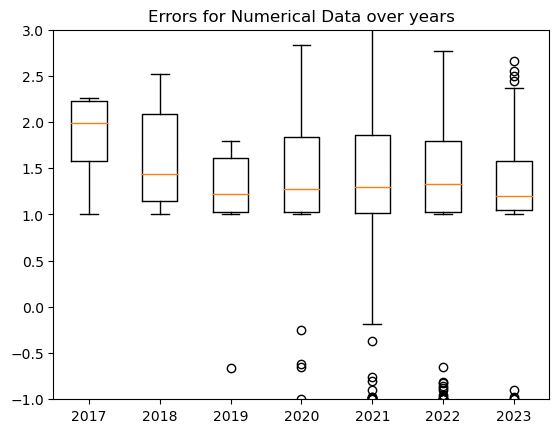

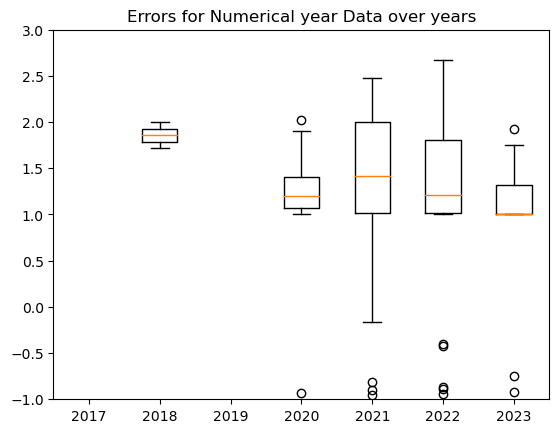

In [56]:
HermesyearsDict = {year: HermesyearsData[year][2] for year in allYears}
HermesyearsDatesDict = {year: HermesyearsData[year][5] for year in allYears}

fig, ax = plt.subplots()
plt.title('Errors for Numerical Data over years')

ax.boxplot(HermesyearsDict.values())
ax.set_xticklabels(HermesyearsDict.keys())
ax.set_ylim([-1, 3])
plt.show()


fig, ax = plt.subplots()
plt.title('Errors for Numerical year Data over years')
ax.boxplot(HermesyearsDatesDict.values())
ax.set_xticklabels(HermesyearsDatesDict.keys())
ax.set_ylim([-1, 3])
plt.show()

In [60]:
X = []
Y = []
for year in allYears:
    X.append(year-0.5)
    X.append(year+0.5)
    Y.append(WLMyearsDict[year][2])
    Y.append(HermesyearsDict[year][2])

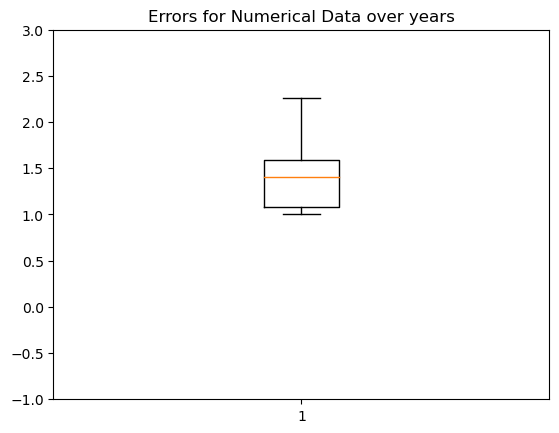

In [63]:
fig, ax = plt.subplots()
plt.title('Errors for Numerical Data over years')

ax.boxplot(Y)
ax.set_ylim([-1, 3])
plt.show()

#### Categories

In [21]:
present = {cat:[] for cat in allCategories}

for i in range(len(HermesTotal['Categories'])):
    HermesTotal['Categories'][i] = ast.literal_eval(HermesTotal['Categories'][i])
    for cat in present:
        if cat in HermesTotal['Categories'][i]:
            present[cat].append(True)
        else:
            present[cat].append(False)

for cat in present:
    HermesTotal[cat] = present[cat]

C:\Users\vetur\AppData\Local\Temp\ipykernel_11236\1736708250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HermesTotal['Categories'][i] = ast.literal_eval(HermesTotal['Categories'][i])


In [24]:
HermescategoriesData = {}
for category in allCategories:
    categoryData = HermesTotal[HermesTotal[category]]
    categoryData = categoryData.reset_index()
    HermescategoriesData[category] = getResults(categoryData)
    print(f'Hermes & {category[:9]} & {round(HermescategoriesData[category][0], 4)} & {round(HermescategoriesData[category][2], 4)} & {round(HermescategoriesData[category][4]/(HermescategoriesData[category][4] + HermescategoriesData[category][1] + HermescategoriesData[category][3]), 4)} \\\ ')
    print("\hline")


Hermes & Technolog & 1.3266 & 1.0044 & 0.7096 \\ 
\hline
Hermes & Political & 1.4126 & 1.1612 & 0.7557 \\ 
\hline
Hermes & Sports & 1.673 & 0.7039 & 0.7797 \\ 
\hline
Hermes & Health an & 1.5244 & 1.1968 & 0.6866 \\ 
\hline
Hermes & Stock Mar & 1.4217 & 1.0048 & 0.6611 \\ 
\hline
Hermes & Supply Ch & 1.3623 & 1.1492 & 0.7326 \\ 
\hline


In [ ]:
HermescatsDict = {cat: HermescategoriesData[cat][2] for cat in allCategories}
HermescatsDatesDict = {cat: HermescategoriesData[cat][5] for cat in allCategories}

fig, ax = plt.subplots()
plt.title('Errors for Numerical Data over categories')

ax.boxplot(HermescatsDict.values())
ax.set_xticklabels(HermescatsDict.keys())
ax.set_ylim([-1, 3])
plt.show()


fig, ax = plt.subplots()
plt.title('Errors for Numerical year Data over categories')
ax.boxplot(HermescatsDatesDict.values())
ax.set_xticklabels(HermescatsDatesDict.keys())
ax.set_ylim([-1, 3])
plt.show()  

### Falcon

In [25]:
FalconData = pd.read_csv('data/Continuous/FalconContinuous0-2536.csv')
FalconData

,Unnamed: 0,predictions
0,0,"45,000"
1,1,The answer is 2045.
2,2,"I'm sorry, I cannot answer that question as it..."
3,3,The first exaflop performer is expected to app...
4,4,The first law concerning artificial intelligen...
...,...,...
2532,2532,The 7-day moving average of daily new reported...
2533,2533,The 7-day moving average of daily new reported...
2534,2534,The 7-day moving average of current confirmed ...
2535,2535,The 7-day moving average of current confirmed ...


In [26]:
nos = []
for row in FalconData['predictions']:
    if not 'i am unable to provide' in row.lower():
        row = re.sub(r'\W+', '', row)
        temp = re.findall(r'\d+', row)
        nos.append(list(map(int, temp)))
    else:
        nos.append([])

FalconTotal = questions.copy(deep=True)
FalconTotal['Predictions'] = nos

In [85]:
getResults(FalconTotal)

(1.1784905309198628, 1213, 1.9997896367132393, 63, 1261)

#### Years

In [86]:
FalconyearsData = {}
for year in allYears:
    yearData = FalconTotal[FalconTotal['Year']==year]
    yearData = yearData.reset_index()
    FalconyearsData[year] = getResults(yearData)

In [88]:
temp1 = FalconTotal[FalconTotal['Year'] < 2022]
temp1 = temp1.reset_index()
getResults(temp1)

(2.03694856838006, 366, 1.2605292218045763, 62, 987)

In [89]:
temp1 = FalconTotal[FalconTotal['Year'] >= 2022]
temp1 = temp1.reset_index()
getResults(temp1)

(1.4271954796706892, 296, 1.2229575684578216, 60, 766)

#### Categories

In [27]:
present = {cat:[] for cat in allCategories}

for i in range(len(FalconTotal['Categories'])):
    FalconTotal['Categories'][i] = ast.literal_eval(FalconTotal['Categories'][i])
    for cat in present:
        if cat in FalconTotal['Categories'][i]:
            present[cat].append(True)
        else:
            present[cat].append(False)

for cat in present:
    FalconTotal[cat] = present[cat]

C:\Users\vetur\AppData\Local\Temp\ipykernel_11236\1147357499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FalconTotal['Categories'][i] = ast.literal_eval(FalconTotal['Categories'][i])


In [28]:
FalconcategoriesData = {}
for category in allCategories:
    categoryData = FalconTotal[FalconTotal[category]]
    categoryData = categoryData.reset_index()
    FalconcategoriesData[category] = getResults(categoryData)
    print(f'Falcon & {category[:9]} & {round(FalconcategoriesData[category][0], 4)} & {round(FalconcategoriesData[category][2], 4)} & {round(FalconcategoriesData[category][4]/(FalconcategoriesData[category][4] + FalconcategoriesData[category][1] + FalconcategoriesData[category][3]), 4)} \\\ ')
    print("\hline")

Falcon & Technolog & 2.1527 & 0.9076 & 0.7447 \\ 
\hline
Falcon & Political & 1.1041 & 0.9056 & 0.746 \\ 
\hline
Falcon & Sports & 1.3468 & 0.7883 & 0.7881 \\ 
\hline
Falcon & Health an & 1.3345 & 1.2015 & 0.7328 \\ 
\hline
Falcon & Stock Mar & 1.5606 & 0.9631 & 0.6731 \\ 
\hline
Falcon & Supply Ch & 1.0717 & 1.1309 & 0.7458 \\ 
\hline
